### Name: Aditya Tripathi
### ID: 202318046

In [ ]:
!pip install pyspark
import torch
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.clustering import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from pyspark.ml.feature import VectorAssembler
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.classification import NaiveBayes
from transformers import BertTokenizer, BertModel
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans as sklearn_kmeans
from pyspark.ml.classification import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer, Word2Vec

In [ ]:
spark = SparkSession.builder.appName("20NewsgroupsClustering").getOrCreate()

In [ ]:

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

data = list(zip(newsgroups['data'], [str(target) for target in newsgroups['target']]))
columns = ["text", "target"]
df = spark.createDataFrame(data, schema=columns)

In [ ]:
# Data Preprocessing
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized = tokenizer.transform(df)
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
stringIndexer = StringIndexer(inputCol="target", outputCol="label")
wordsData = tokenizer.transform(df)
featurizedData = hashingTF.transform(wordsData)
vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7, stop_words='english')
X = vectorizer.fit_transform(newsgroups.data)
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_reduced = lsa.fit_transform(X)


In [ ]:

kmeans = KMeans().setK(20).setSeed(1)  # Assuming we want to cluster into 20 groups as there are 20 newsgroups
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, kmeans])
model = pipeline.fit(df)
predictions = model.transform(df)
predictions.select("text", "prediction").show()

+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|\n\nI am sure som...|         0|
|My brother is in ...|         0|
|\n\n\n\n\tFinally...|         0|
|\nThink!\n\nIt's ...|         0|
|1)    I have an o...|         0|
|\n\nBack in high ...|         0|
|\n\nAE is in Dall...|         0|
|\n[stuff deleted]...|         0|
|\n\n\nYeah, it's ...|         0|
|\nIf a Christian ...|         0|
|the blood of the ...|         0|
| >say they have a...|         0|
|930418\n\nDo what...|        19|
| How about Kirlia...|         0|
|\n\n\tThere is no...|         0|
|In the following ...|         0|
|Many thanks to th...|         0|
|.........\nI, som...|         0|
|\nThe Supreme Cou...|        19|
|\ned>1.  All of u...|         0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
naive_bayes = NaiveBayes()
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, stringIndexer, naive_bayes])
(train_set, test_set) = df.randomSplit([0.8, 0.2], seed=1234)
model = pipeline.fit(train_set)
predictions = model.transform(test_set)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.4085252846174212


In [ ]:
# TF-IDF
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("text", "features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="features")


model = word2Vec.fit(tokenized)

result = model.transform(tokenized)

result.select("text", "features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Bert Embedding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


text = df.collect()

# embedding
embeddings = []
for i in text:
    inputs = tokenizer(i["text"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    # Example: Use the mean of the last hidden state as the document embedding
    embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())


df = pd.DataFrame({'embedding': embeddings})
df.to_parquet('embeddings.parquet')

df_embeddings = spark.read.parquet('path/to/embeddings.parquet')

# Convert the embedding column (list) into a Dense Vector
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_embeddings = df_embeddings.withColumn("features", to_vector("embedding"))

# Use the embeddings for machine learning
lr = LogisticRegression(featuresCol='features', labelCol='label')
model = lr.fit(df_embeddings)

# Predictions
predictions = model.transform(df_embeddings)

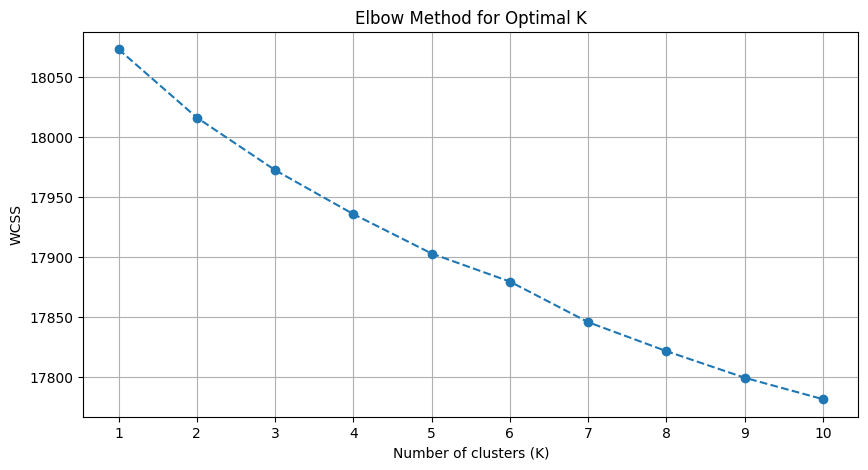

In [ ]:
# Elbow Method (WCSS)
wcss = []

#different values of K
for k in range(1, 11):  # Adjust the range of K as needed
    kmeans = sklearn_kmeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

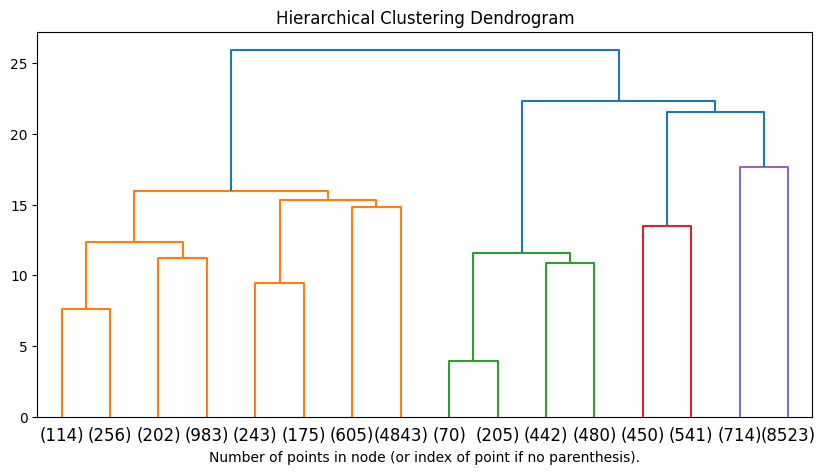

In [ ]:
# Agglomerative Clustering
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
clustering.fit(X_reduced)

# Function to plot the dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    
    dendrogram(linkage_matrix, **kwargs)

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
spark.stop()